# Neurophysiological eyetracker: binocular data, cyclops model

In [1]:
import sys
import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

if myhost=='it':
    sys.path.insert(0, '/home/felixbartsch/Code/') 
    datadir = '/home/felixbartsch/Data/Conway/'  
    dirname = '/home/felixbartsch/Data/Colorworkspace/' # Working directory 
else:
    sys.path.insert(0, '/home/conwaylab/Git/') 
    datadir = '/home/conwaylab/Data/'  
    dirname = '/home/conwaylab/Analysis/Colorworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#deviceA = torch.device('cuda:0')
#device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

Running on Computer: [m1]
Invoking __init__.py for NDNT.utils
Save_dir = /home/felixbartsch/Data/Colorworkspace/
cuda:0


In [2]:
fndate= '241126' #this should be the date of the recording in YYMMDD, used for our naming conventions
monkeyID = 'J' # J for Jocamo, V for Vincent, S for Sprout

#local data structs
dirname2 = dirname+fndate+'/'
dirname_mod = dirname+fndate+'/models/'

#data directory structs
PROOT = monkeyID+fndate 
fn = PROOT+'_CC_CC' # '_CC_CC' for Color Cloud data, replace this with '_MkTurk' if doing task analysis
fn0 = fn+'_v09' #current version of this code

datadir2 = datadir+'proc/'+PROOT+'/'
analdir = datadir+'analysis/'+PROOT+'/'
moddir = datadir+'models/'+PROOT+'/'

In [3]:
# Load data (all stim)

inclMUs = True
t0 = time()
data = datasets.ColorClouds(
    filenames=[fn0], eye_config=3, drift_interval=16, 
    datadir=datadir2, luminance_only=True, binocular=False,
    trial_sample=True, folded_lags=False,
    include_MUs=inclMUs)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir2+fn+'_DFupdate.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir2+fn+'_ETupdate.mat')
data.process_fixations(matdat['sac_binsB'][0, :])

# Pull correct fixations
NFIX = torch.max(data.fix_n).detach().numpy() 
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
#et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = 0.000 | 0.269
T-range: 0 154320
  Trimming experiment 254160->154320 time points based on eye_config and Tmax
106.74826455116272 sec elapsed
154320 (154320 valid) time points
17 laminar units, 147 ET units
  Redoing fix_n with saccade inputs: 5443 saccades
6033 fixations


In [4]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on the full dataset, to LLsNULL_ET, which is based on the subset of cells

# Read in previous data
matdat = sio.loadmat(datadir2+PROOT+'_UT_GLM_info.mat')
LLsNULL = matdat['LLsNULL'][:, 0]
LLsGLM = matdat['LLsGLM'][:, 0]
#drift_terms = matdat['drift_terms']
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][0]
#RFcenters0 = matdat['RFcenters'][valET, :]

adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', 
    batch_size=10, #2000
    num_workers=0,
    learning_rate=0.01, early_stopping_patience=6,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_pars['device'] = device

data.set_cells(valET)

126 out of 140 units used
Output set to 126 cells


In [5]:
top_corner = matdat['top_corner'][0]
print(top_corner)

num_lags = 10
Xshift = 0 #17
Yshift = 0
NX = 60

new_tc = np.array([top_corner[0]+Xshift, top_corner[1]+Yshift], dtype=np.int64)

[925 515]


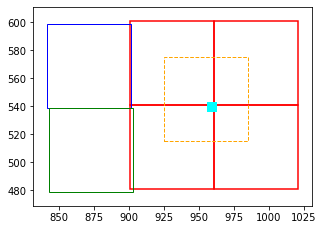

  Writing lam stim 0: overlap 36, 26
  Writing lam stim 1: overlap 36, 34
  Writing lam stim 2: overlap 24, 34
  Writing lam stim 3: overlap 24, 26
  Adding fixation point
  Done


In [6]:
# assemble stimulus
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(
    top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, time_embed=0, num_lags=num_lags)

In [7]:
## Calculate STAS
lag = 4
stasC = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([1, NX,NX,-1]).numpy()
stasC.shape

/tmp/ipykernel_3620692/2439341685.py:3: RuntimeWarning: invalid value encountered in true_divide
  stasC = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([1, NX,NX,-1]).numpy()


(1, 60, 60, 140)

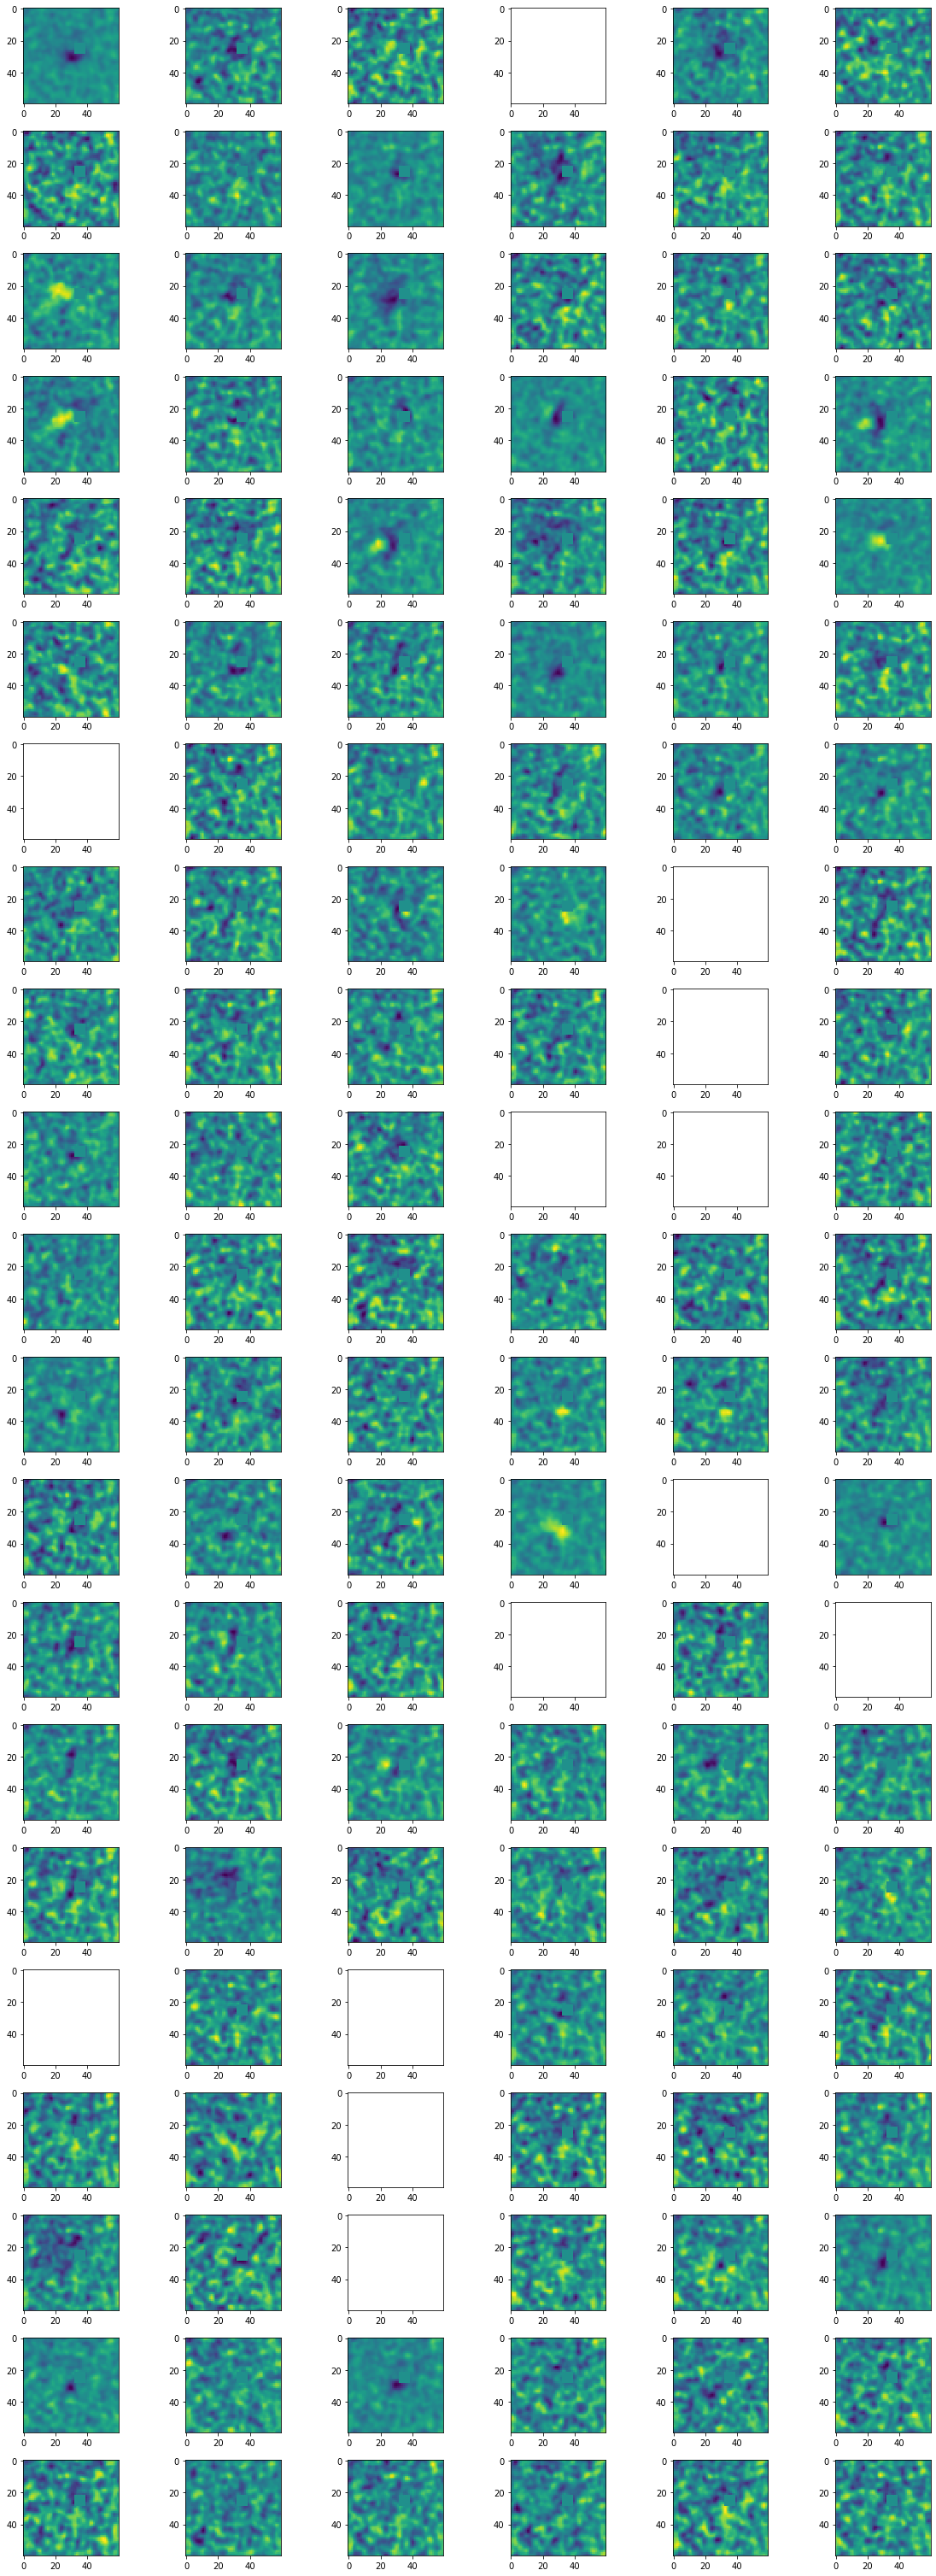

In [8]:
ctext = ['Lum', 'L-M', 'S']
nrows=int(np.ceil(NCv/6))
ss(nrows, 6, rh=2)
for cc in range(NCv):
    plt.subplot(nrows, 6, cc+1)
    imagesc(stasC[0, :, :, cc])

In [9]:
# Load models and verify
with open(moddir+'UT_drift_pop.pkl', 'rb') as f:
    drift_all = dill.load(f)
LLsTest1 = drift_all.eval_models(data[data.val_blks], null_adjusted=False)
print("Drift model verify:", np.mean(LLsNULL), np.mean(LLsTest1))
drift_terms = drift_all.networks[0].layers[0].weight.data.numpy()
#with open(moddir+'UT_GLM_ET_pop.pkl', 'rb') as f:
#    glms_all = dill.load(f)
#LLsTest2 = glms_all.eval_models(data[data.val_blks], null_adjusted=False)
print("LLsGLM:", np.mean(LLsGLM))  # Note different stim so RFs would have to move....


Drift model verify: 2.625989323097562 2.6259892
LLsGLM: 0.0016073201383863176


## Scaffold CNN

In [10]:
matdat = sio.loadmat(datadir2+PROOT+'_UT_GLM_info.mat')

RFcenters0 = matdat['RFcenters']
RFcenters = deepcopy(RFcenters0)
RFcenters[:, 0] = RFcenters0[:, 0] - Xshift
RFcenters[:, 1] = RFcenters0[:, 1] - Yshift

# if RF centers were adjusted to pixel coordinates
if np.mean(RFcenters[:,0])>60:
    RFcenters[:, 0] = RFcenters0[:, 0] - new_tc[0]
    RFcenters[:, 1] = RFcenters0[:, 1] - new_tc[1]
mu0s = utils.pixel2grid(deepcopy(RFcenters[:, [1, 0]]), L=NX)

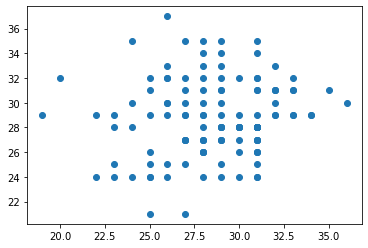

In [11]:
plt.plot(RFcenters[:, 0], RFcenters[:, 1],'o')
plt.show()

In [12]:
## TRY E-I
## Try Hamming window -- increase by 2 on a side?
Treg = 0.0001
Xreg = 0.0004
Mreg = 0.0001
Creg = 0.001
Dreg = 0.5
Gnet = 0.001

## CORE-SCAFFOLD
num_subs = [8, 24, 16]
fws = [7, 13, 5]

clayers = []
ii=0

clayers.append(
    STconvLayer.layer_dict( 
        input_dims=[1,NX,NX,1], num_filters=num_subs[ii], bias=False, num_lags=num_lags,
        filter_dims=[1,NX,NX,num_lags], NLtype='lin', initialize_center = True) )
clayers[0]['reg_vals'] = {'d2x': Xreg, 'glocalx': Gnet,'edge_t':10} 

ii=1
clayers.append(
    ConvLayer.layer_dict( 
        num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
        filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
clayers[ii]['output_norm'] = 'batch'
clayers[ii]['window']='hamming'
clayers[ii]['pos_constraint'] = True
clayers[ii]['reg_vals'] = {'glocal': Gnet}  

ii=2
clayers.append(
    ConvLayer.layer_dict( 
        num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
        filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
clayers[ii]['output_norm'] = 'batch'
clayers[ii]['window']='hamming'
clayers[ii]['pos_constraint'] = True
clayers[ii]['reg_vals'] = {'glocal': Gnet}  


scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

## 1: READOUT
readout_pars = ReadoutLayer.layer_dict(
    num_filters=NCv, NLtype='lin', bias=False, pos_constraint=True)
readout_pars['gauss_type'] = 'isotropic'
readout_pars['reg_vals'] = {'max': Mreg} 

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

## 2: DRIFT
drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

## 3: COMB 
comb_layer = ChannelLayer.layer_dict(
    num_filters = NCv, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')

cnn1 = NDN.NDN( 
    ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')

cnn1.block_sample=True

## Network 1: readout: fixed mus / sigmas
cnn1.networks[1].layers[0].sample = False
cnn1.networks[1].layers[0].mu.data = torch.tensor( mu0s, dtype=torch.float32)
cnn1.networks[1].set_parameters(val=False, name='mu')
cnn1.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn1.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn1.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn1.networks[3].set_parameters(val=False, name='weight')

cnn1.list_parameters()
#cnn1 = cnn1.to(device)

ConvDim 1 should be odd.
ConvDim 2 should be odd.
Network 0:
  Layer 0:
      weight: torch.Size([36000, 8])
  Layer 1:
      weight: torch.Size([1352, 24])
  Layer 2:
      weight: torch.Size([600, 16])
Network 1:
  Layer 0:
      weight: torch.Size([48, 126])
      NOT FIT: mu: torch.Size([126, 2])
      NOT FIT: sigma: torch.Size([126, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([41, 126])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 126])
      bias: torch.Size([126])


In [13]:
cnn1.fit( data, **adam_pars, verbose=2, version=1 )
LLsC1 = cnn1.eval_models(data[data.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLsC1))

Model: M126_CsCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.659]


Train loss: 0.65894356


Epoch 2: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.605]


Train loss: 0.60501513


Epoch 3: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60422475


Epoch 4: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60398529


Epoch 5: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60359822


Epoch 6: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60359141


Epoch 7: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60372068


Epoch 8: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60362587


Epoch 9: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60365230


Epoch 10: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60368718


Epoch 11: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60377081


Epoch 12: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60362681


Epoch 13: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60360592


Epoch 14: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60362954


Epoch 15: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60365855


Validating ver=1: 100%|████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it, val_loss=0.528]


Early stopping
Done fitting
  Fit complete: 2784.538930416107 sec elapsed
0.0038311699080088783


In [14]:
LLsNULL-LLsC1

array([ 2.24423409e-02,  4.71663475e-03,  2.45022774e-03,  7.89713860e-03,
        5.09767532e-02,  1.12223625e-03,  1.88112259e-04,  3.72147560e-03,
        4.70018387e-03,  4.18663025e-04,  6.59108162e-04,  1.83911324e-02,
        5.12552261e-03,  7.99798965e-03,  3.36408615e-04,  4.18925285e-03,
        1.07860565e-03,  3.59137058e-02,  8.07762146e-04,  1.13034248e-03,
        5.82456589e-03, -3.96966934e-04,  6.83832169e-03,  1.12056732e-05,
        7.52925873e-04,  6.43992424e-03,  1.80032253e-02,  2.95257568e-03,
        1.38425827e-02,  4.79698181e-04,  2.13408470e-03,  1.78456306e-04,
        5.12671471e-03,  2.42209435e-03,  3.34095955e-03,  2.51781940e-03,
        1.77872181e-03,  1.64389610e-03,  9.15050507e-04,  1.43408775e-03,
        2.39396095e-03,  1.80959702e-04,  1.29890442e-03,  4.59575653e-03,
        1.34706497e-05, -6.02006912e-04,  4.57286835e-04,  5.63859940e-04,
        2.19941139e-04,  2.79688835e-03, -1.52754784e-03,  1.52826309e-04,
        1.84535980e-04,  

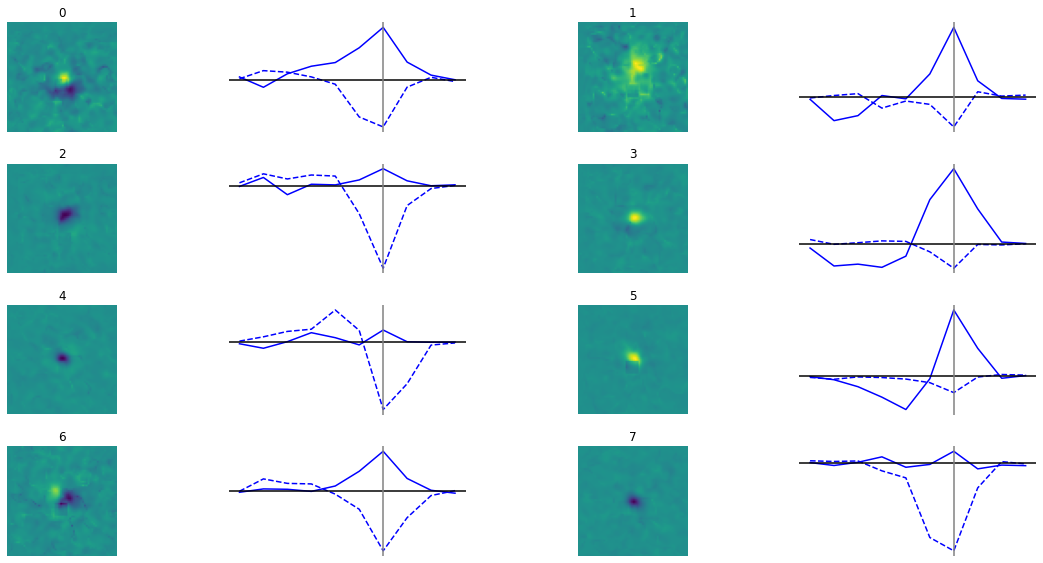

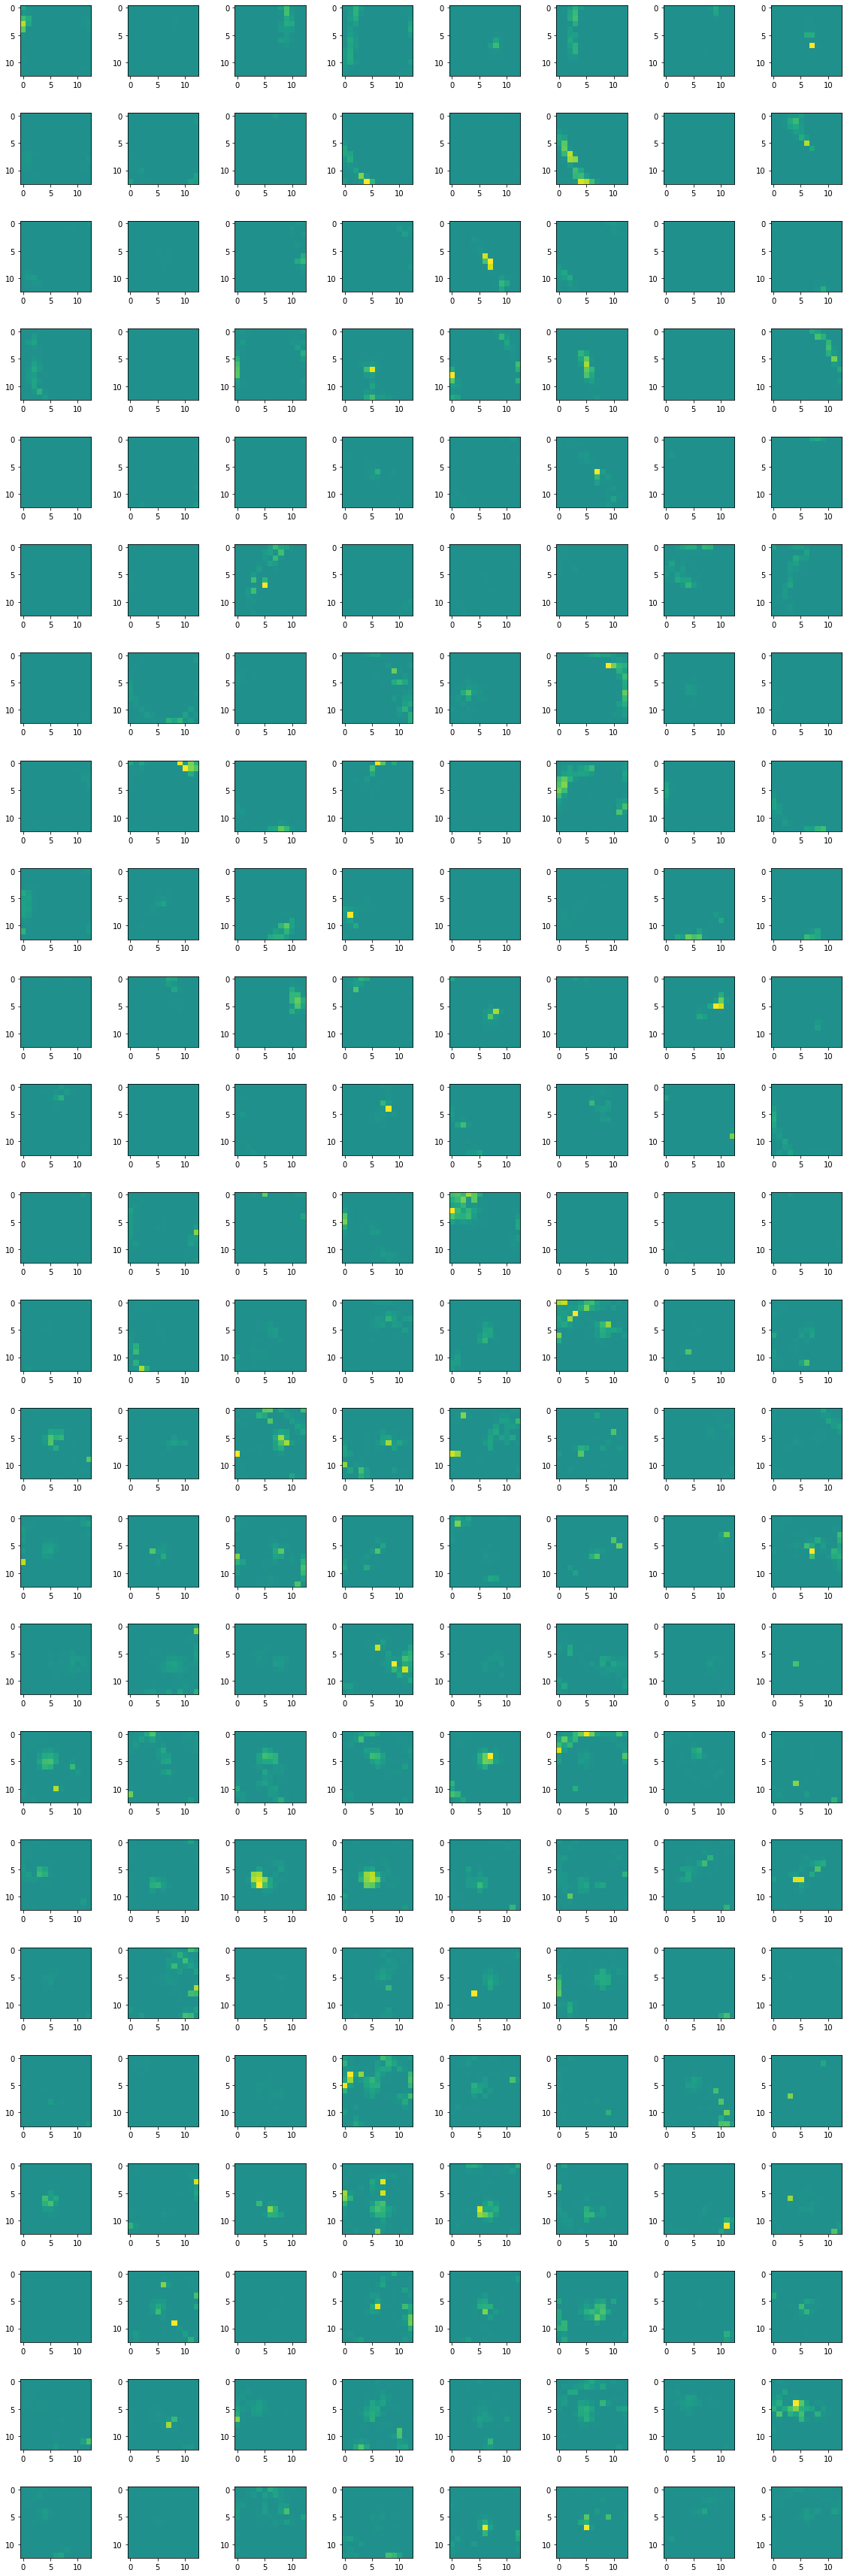

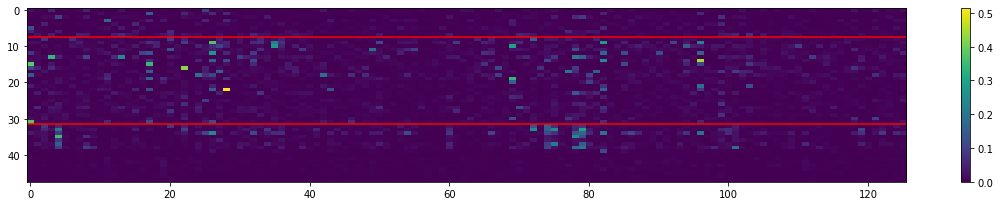

[0.10353079 0.63800492 0.2584643 ]


In [15]:
CU.display_cnn(cnn1)

In [16]:
cnn1.networks[1].set_parameters(val=True)
cnn1.networks[0].layers[0].reg.vals['d2x'] = 0.0001
cnn1.networks[0].layers[0].reg.vals['glocalx'] = 0.00005
cnn1.networks[1].layers[0].sample = True
cnn1.fit( data, **adam_pars, verbose=2 , version=2 )
LLsC2 = cnn1.eval_models(data[data.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLsC1), np.mean(LLsNULL-LLsC2))

Model: M126_CsCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.605]


Train loss: 0.60466497


Epoch 2: 100%|███████████████████████████████████████| 52/52 [02:37<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60394659


Epoch 3: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60395590


Epoch 4: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.604]


Train loss: 0.60390290


Epoch 5: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60377858


Epoch 6: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60391019


Epoch 7: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60382745


Epoch 8: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60381011


Epoch 9: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60374728


Epoch 10: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60353206


Epoch 11: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60371510


Epoch 12: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60376976


Epoch 13: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60370859


Epoch 14: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60358362


Epoch 15: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60369381


Epoch 16: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.604]


Train loss: 0.60356631


Epoch 17: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.604]


Train loss: 0.60371960


Validating ver=2: 100%|████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it, val_loss=0.528]


Early stopping
Done fitting
  Fit complete: 3147.111921310425 sec elapsed
0.0038311699080088783 0.003901712005100553


In [17]:
## CHECK MUS -- did they shift?
#mu1s = cnn1.networks[1].layers[0].mu.data.detach().numpy()
mu1s = cnn1.networks[1].layers[0].mu.data.cpu().numpy()

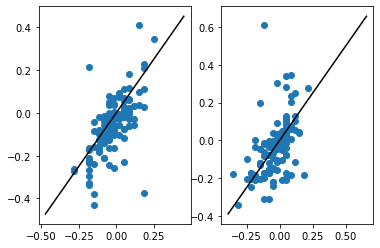

In [18]:
plt.subplot(121)
plt.plot(mu0s[:,0], mu1s[:,0],'o')
ys = plt.ylim()
plt.plot(ys,ys,'k')
plt.subplot(122)
plt.plot(mu0s[:,1], mu1s[:,1],'o')
ys = plt.ylim()
plt.plot(ys,ys,'k')
plt.show()

Text(0, 0.5, 'CNN1')

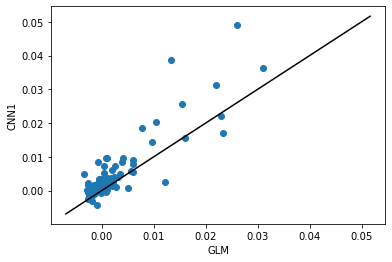

In [19]:
LLsCNN1 = LLsNULL-LLsC2
plt.plot(LLsGLM,LLsCNN1,'o')
ys = plt.ylim()
plt.plot(ys,ys,'k')
plt.xlabel('GLM')
plt.ylabel('CNN1')

In [20]:
# Just use cnn1 for first iteration
cnn1.save_model(filename=moddir+'cnn'+fndate+'bdata0.pkl')

  Saving model at /Data/FelixData/Conway/proc/J220711/models/cnn0711bdata0.pkl


In [21]:
with open(moddir+'cnn'+fndate+'bdata0.pkl', 'rb') as f:
    cnn1 = dill.load(f)

## Shifts

17 42 19 48 26 30
Using sh = 11 with L=39


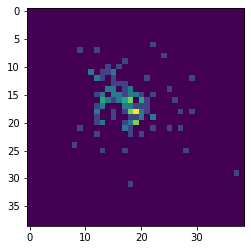

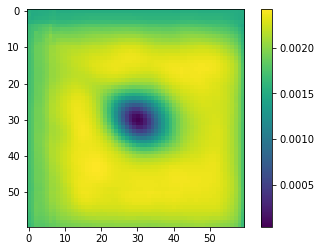

(3.699173976201564e-05, [30, 30])

In [22]:
cnn1C, sh1C, LC = ETutils.convolutional_convert_cnn(cnn1.cpu(), verbose=1)

preds0 = cnn1(data[:10]).detach().numpy()
predsC = cnn1C(data[:10]).reshape([preds0.shape[0],NCv,NX,NX]).detach().numpy()
sims = np.zeros([NX, NX])
for ii in range(NX):
    for jj in range(NX):
        sims[ii,jj] = np.mean(np.square(preds0-predsC[:,:,ii,jj]))
imagesc(sims)
plt.colorbar()
plt.show()
cntr1 = utils.max_multiD(-sims)

np.min(sims), cntr1

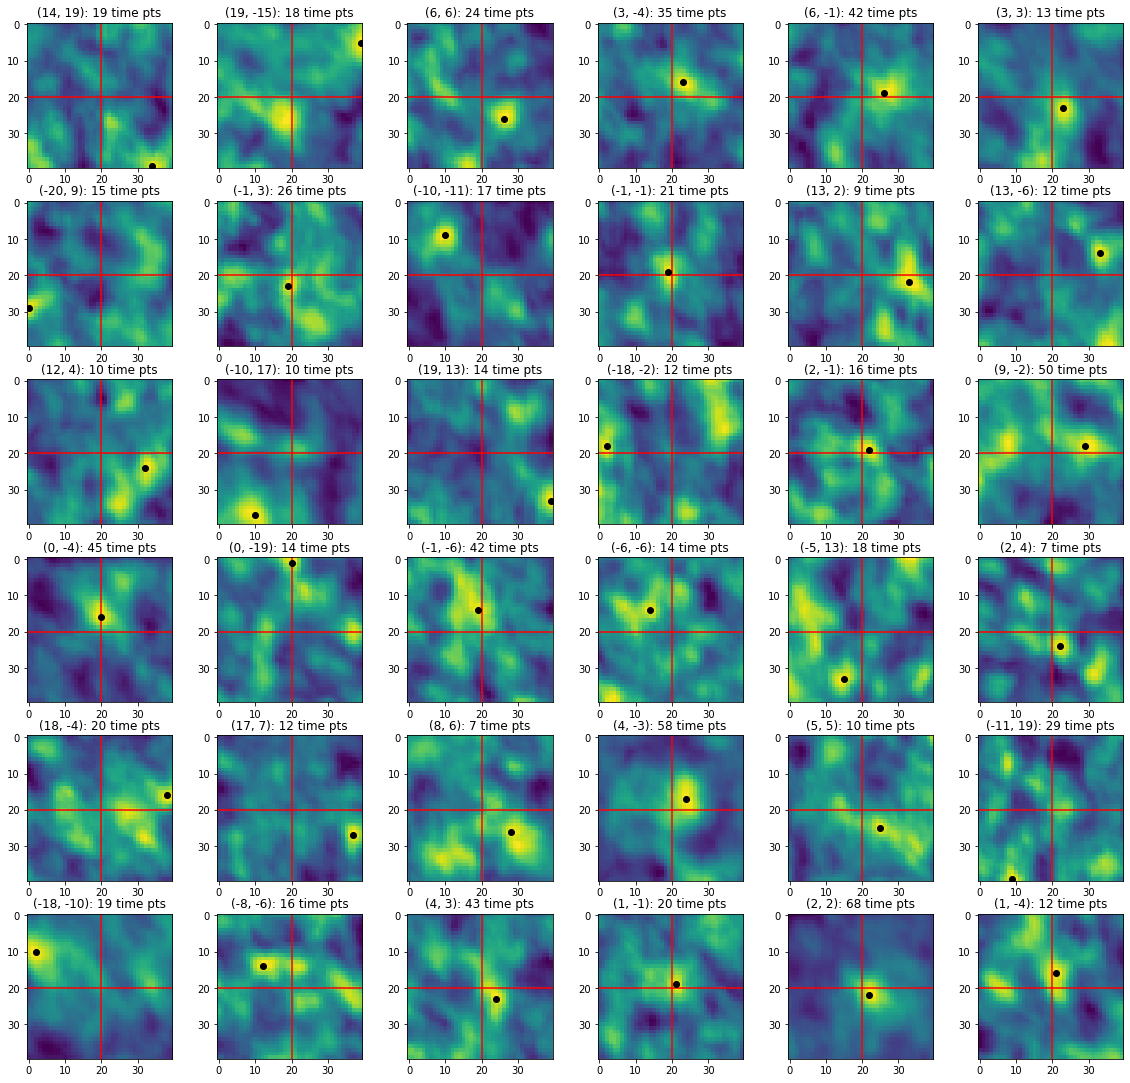

In [23]:
edge1 = 10
#res0 = ETutils.compute_LLsurfaces( 
#    data, cnn1C, drift_all, fixations=np.arange(10), # np.arange(Lfix_range[0], Lfix_range[0]+12),
#    edge=edge1, ctr = cntr1, display=True)
maxblk = np.max([np.max(data.train_blks), np.max(data.val_blks)])

data.trial_sample=False # set as kludge for computing LLsurfaces
res0 = ETutils.compute_LLsurfaces(
    data, cnn1C, drift_all, edge=edge1, ctr=cntr1, extra_data=True,
    fixations=np.arange(36), wpriors=1e-4, device=device, display=True)

In [24]:
Ngroups = 4
priors = [1e-4, 3e-3, 1e-3, 3e-2]

fixgroups = []
for nn in range(Ngroups):
    if nn == Ngroups-1:
        ender = NFIX
    else:
        ender = ((nn+1)*NFIX)//Ngroups

    fixgroups.append(np.arange(nn*NFIX//Ngroups, ender))


thresh_metrics = []
resCNN = []

data.trial_sample=False # set as kludge for computing LLsurfaces
for ii in range(Ngroups):
    print( 'Fix group', ii)
    resCNN.append( 
        ETutils.compute_LLsurfaces(data, cnn1C, drift_all, edge=edge1, ctr=cntr1, extra_data=True,
                                   fixations=fixgroups[ii], wpriors=priors, device=device) )
    thresh_ms = np.zeros(len(fixgroups[ii]))
    for ff in range(len(fixgroups[ii])):
        _, thresh_ms[ff] = CU.surf2D_quality_scan( resCNN[-1]['LLsurfaces'][ff,:,:,0] )
    thresh_metrics = np.concatenate( (thresh_metrics, thresh_ms), axis=0 )
#ETnim = stitch_results( resNIM )
ETcnn = CU.stitch_results( resCNN )

Fix group 0
  500 fixations
  1000 fixations
  1500 fixations
Fix group 1
  500 fixations
  1000 fixations
  1500 fixations
Fix group 2
  500 fixations
  1000 fixations
  1500 fixations
Fix group 3
  500 fixations
  1000 fixations
  1500 fixations


In [25]:
# Load data (all stim)
inclMUs = True
t0 = time()
data2 = datasets.ColorClouds(
    filenames=[fn0], eye_config=3, drift_interval=16, 
    datadir=datadir2, luminance_only=True, binocular=False,
    trial_sample=True, folded_lags=False,
    include_MUs=inclMUs)
t1 = time()
print(t1-t0, 'sec elapsed')

# Replace DFs
matdat = sio.loadmat(datadir2+fn+'_DFupdate.mat')
data2.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir2+fn+'_ETupdate.mat')
data2.process_fixations(matdat['sac_binsB'][0, :])

#sac_ts_all = matdat['sac_binsB'][0, :]
#data2.process_fixations( sac_ts_all )

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = 0.000 | 0.269
T-range: 0 154320
  Trimming experiment 254160->154320 time points based on eye_config and Tmax
85.53210663795471 sec elapsed
  Redoing fix_n with saccade inputs: 5443 saccades


In [26]:
#val_ds = GenericDataset(data[data.val_blks], device=device)
#cnn1x = cnn1.to(device)
#LLs0 = cnn1.eval_models(val_ds, null_adjusted=False)
#print("U: %0.8f\tXV: %0.8f"%(np.mean(LLsNULL[Ukeeps]-LLs0[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0[XVkeeps])) )

In [27]:
# COMPUTE OPTIMAL PERFORMACE USING Xval;
Ukeeps = ETcnn['Ctrain']
XVkeeps = ETcnn['Cval']

NP = len(priors)
LLet = np.zeros([NP, 2])
data2.set_cells(valET)
#qs = [0, 0.05, 0.01, 0.2, 0.3]  # how much data to throw out based on metrics
# metric_thresholds = []
#     cuts = np.quantile(ETcnn['metrics'][:, pp], qs)
#     metric_thresholds.append(deepcopy(cuts))

# Old comparison
#print("Train   \tValidation")
#print("%8.6f\t%8.6f"%(np.mean(LLsNULL[Ukeeps]-LLs0[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0[XVkeeps])) )

for pp in range(NP):
    print( "  Prior = %f of %f" %(priors[pp], NP))
    shifts = ETcnn['shifts'][:, :, pp] - NX//2 + edge1
    new_stim2 = data.shift_stim( -shifts  )
    data2.stim = new_stim2.reshape([NT,-1])
  
    torch.cuda.empty_cache()
    val_dsN = GenericDataset(data2[data.val_blks], device=device)

    LLsN = cnn1.eval_models(val_dsN, null_adjusted=False)
    print("p%d: %8.6f\t%8.6f"%(pp, np.mean(LLsNULL[Ukeeps]-LLsN[Ukeeps]), 
                                  np.mean(LLsNULL[XVkeeps]-LLsN[XVkeeps])) )
    LLet[pp, 0] = np.mean(LLsNULL[XVkeeps]-LLsN[XVkeeps])  # XVcells
    LLet[pp, 1] = np.mean(LLsNULL[Ukeeps]-LLsN[Ukeeps])  
    del val_dsN

Output set to 126 cells
  Prior = 0.000100 of 4.000000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


p0: -0.004559	-0.004929
  Prior = 0.003000 of 4.000000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


p1: -0.004760	-0.004642
  Prior = 0.001000 of 4.000000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]


p2: -0.004452	-0.004577
  Prior = 0.030000 of 4.000000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [01:48<00:00,  3.50s/it]

p3: -0.004439	-0.004510


### Generate shifts 

In [28]:
pp = 1
shifts = deepcopy(ETcnn['shifts'][:, :, pp]) - NX//2 + edge1
fix_n = deepcopy(data.fix_n.detach().numpy())
metricsLL = deepcopy(ETcnn['metrics'][:,pp])
metricsTH = deepcopy(thresh_metrics)
shifts.shape, fix_n.shape, metricsLL.shape, metricsTH.shape

((6033, 2), (154320,), (6033,), (6033,))

In [29]:
# Make continuous-in-time
ETshifts = np.zeros([data.NT,2], dtype=np.float32)
ETmetrics = np.zeros([data.NT,2], dtype=np.float32)
for ff in range(NFIX):
    ts = np.where(fix_n == (ff+1))[0]
    ETshifts[ts, 0] = shifts[ff,0]
    ETshifts[ts, 1] = shifts[ff,1]
    ETmetrics[ts, 0] = metricsLL[ff]
    ETmetrics[ts, 1] = metricsTH[ff]

sio.savemat( datadir2 + fn + '_shifts0.mat', {
           'fix_n': fix_n, 'shifts': shifts, 'metricsLL': metricsLL, 'metricsTH': metricsTH,
           'ETshifts': ETshifts, 'ETmetrics': ETmetrics, 'Ctrain': Ukeeps, 'Cval': XVkeeps} )
sio.savemat( datadir2 + fn + '_shifts_best.mat', {
           'fix_n': fix_n, 'shifts': shifts, 'metricsLL': metricsLL, 'metricsTH': metricsTH,
           'ETshifts': ETshifts, 'ETmetrics': ETmetrics, 'Ctrain': Ukeeps, 'Cval': XVkeeps} )

# Second iteration

In [30]:
# Load data (all stim)
#fn = 'Jocamo_220808_full_CC_ETCC_nofix_v08'
#fndate= '0808'
#dirname2 = dirname+fndate+'/'
#dirname_mod = dirname+fndate+'/models/'

inclMUs = True
t0 = time()
data2 = datasets.ColorClouds(
    filenames=[fn0], eye_config=3, drift_interval=16, 
    datadir=datadir2, luminance_only=True, binocular=False,
    trial_sample=True, folded_lags=False,
    include_MUs=inclMUs)

t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir2+fn+'_DFupdate.mat')
data2.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir2+fn+'_ETupdate.mat')
data2.process_fixations(matdat['sac_binsB'][0, :])

#sac_ts_all = matdat['ALLsac_bins'][0, :]
#data.process_fixations( sac_ts_all )

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = 0.000 | 0.269
T-range: 0 154320
  Trimming experiment 254160->154320 time points based on eye_config and Tmax
85.44059634208679 sec elapsed
154320 (154320 valid) time points
17 laminar units, 147 ET units
  Redoing fix_n with saccade inputs: 5443 saccades


In [31]:
# Restarted from first block (reading in data and LLnulls)
# now load shifts and previous models
# Load shifts

SHfile = sio.loadmat( datadir2 + fn + '_shifts0.mat' )
fix_n = SHfile['fix_n'][0, :]
#fix_n[len(fix_n)-1]=np.max(fix_n)
#data2.fix_n = fix_n

shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL'][0,:]
metricsTH = SHfile['metricsTH'][0,:]
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain'][0,:]
XVkeeps = SHfile['Cval'][0,:]

data2.assemble_stimulus(
    top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, time_embed=0, num_lags=num_lags, shifts=-shifts)
#    top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, time_embed=2, num_lags=num_lags, shifts=-shifts)

#SHstim1 = ETutils.shift_stimulus( data2.stim, ETshifts, stim_dims=data2.stim_dims )
# This currently does not work with lags

  Stim expansion for shift: [905, 495, 1005, 595]
  Writing lam stim 0: overlap 56, 46
  Writing lam stim 1: overlap 56, 54
  Writing lam stim 2: overlap 44, 54
  Writing lam stim 3: overlap 44, 46
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [32]:
# Previous models 
# drift_all already on with LLsNULL
data2.set_cells(valET)
with open(moddir+'cnn'+fndate+'bdata0.pkl', 'rb') as f:
    cnn1x = dill.load(f)
LLs0 = cnn1x.eval_models(data[data.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs0), np.mean(LLsNULL[Ukeeps]-LLs0[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0[XVkeeps]))

# and on shifted stimulus
LLs0sh = cnn1x.eval_models(data2[data.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs0sh), np.mean(LLsNULL[Ukeeps]-LLs0sh[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0sh[XVkeeps]))

Output set to 126 cells
-0.012225078211890327 -0.054831358465817895 0.15990429401397704
0.007624297861068967 0.008483206871712562 0.004154305458068847


In [33]:
metricsTH.shape

(6033,)

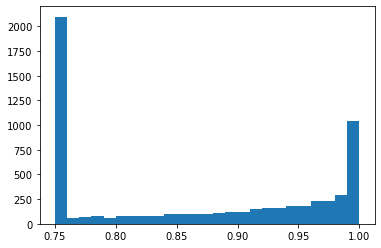

In [34]:
# Check metrics on histogram 
plt.hist(metricsTH,bins=25)
plt.show()

In [35]:
goodfix = np.where(ETmetrics[:,1] < 0.95)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data2.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

73.1% fixations remaining


In [36]:
print(torch.sum(data.dfs_out,axis=0)[:4])
print(torch.sum(data2.dfs_out,axis=0)[:4])

tensor([154320., 154320., 154320., 154320.])
tensor([112739., 112739., 112739., 112739.])


In [37]:
LLs0df = cnn1x.eval_models(data2[data2.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs0df), np.mean(LLsNULL[Ukeeps]-LLs0df[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0df[XVkeeps]))

0.007321199254384117 0.008734270487681474 0.0016123914718627929


In [38]:
## FIT MODELS TO THIS SUBSET OF DATA
cnn2 = deepcopy(cnn1x)
#cnn2.list_parameters()
cnn2.fit( data2, **adam_pars, verbose=2 , version=3)
LLs2 = cnn2.eval_models(data2[data2.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs0df), np.mean(LLsNULL-LLs2))

Model: M126_CsCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1: 100%|███████████████████████████████████████| 52/52 [02:34<00:00,  2.98s/it, train_loss=0.459]


Train loss: 0.45925692


Epoch 2: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45826842


Epoch 3: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45775234


Epoch 4: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45901905


Epoch 5: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45833416


Epoch 6: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45875660


Epoch 7: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45757868


Epoch 8: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45883216


Epoch 9: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45881348


Epoch 10: 100%|██████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45761648


Epoch 11: 100%|██████████████████████████████████████| 52/52 [02:35<00:00,  3.00s/it, train_loss=0.458]


Train loss: 0.45763148


Validating ver=3: 100%|████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it, val_loss=0.387]


Early stopping
Done fitting
  Fit complete: 2027.0429708957672 sec elapsed
0.007321199254384117 0.009225711462989686


In [39]:
cnn2eye = deepcopy(cnn2)
cnn2eye.networks[1].set_parameters(val=True)
cnn2eye.networks[1].layers[0].sample = True
cnn2eye.fit( data2, **adam_pars, verbose=2 , version=4)
LLs2e = cnn2eye.eval_models(data2[data2.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs2), np.mean(LLsNULL-LLs2e))

Model: M126_CsCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1: 100%|███████████████████████████████████████| 52/52 [02:35<00:00,  2.99s/it, train_loss=0.459]


Train loss: 0.45862181


Epoch 2: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45832070


Epoch 3: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45880926


Epoch 4: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45863574


Epoch 5: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.457]


Train loss: 0.45742300


Epoch 6: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45855586


Epoch 7: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45847213


Epoch 8: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45856638


Epoch 9: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45876367


Epoch 10: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45796233


Epoch 11: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45829487


Epoch 12: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45836469


Epoch 13: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45836765


Epoch 14: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45866837


Epoch 15: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45787259


Epoch 16: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45848654


Epoch 17: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45838897


Epoch 18: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45892681


Epoch 19: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45895335


Validating ver=4: 100%|████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it, val_loss=0.387]


Early stopping
Done fitting
  Fit complete: 3515.4241461753845 sec elapsed
0.009225711462989686 0.00996118736645532


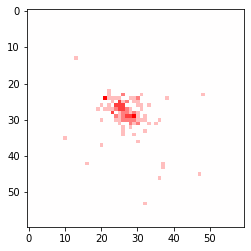

In [40]:
# NEED TO PUT BACK ON GRID AND CORRECT ANY STRAGGLERS
# Readout layer conversion -> convolutional layer with single weight -- need relative positions
mus = cnn2eye.networks[1].layers[0].mu.data.cpu().detach().numpy()
musP = utils.grid2pixel(mus, enforce_bounds=True, L=NX, force_int=True)

sp2d = np.zeros([NX, NX])
for cc in range(NCv):
    sp2d[musP[cc,0], musP[cc,1]] += 1

    imagesc(sp2d, aspect=1, cmap='bwr')
plt.show()

In [41]:
# Refit with pixelized cell positions
cnn2x = deepcopy(cnn2eye)
new_mus = utils.pixel2grid(musP, L=NX)
cnn2x.networks[1].layers[0].mu.data = torch.tensor(new_mus, dtype=torch.float32)
cnn2x.networks[1].set_parameters(val=False, name='mu')
cnn2x.networks[1].set_parameters(val=False, name='sigma')
cnn2x.networks[1].layers[0].sample = False
cnn2x.list_parameters()

cnn2x.fit( data2, **adam_pars, verbose=2 , version=5)
LLs2x = cnn2x.eval_models(data2[data2.val_blks], null_adjusted=False)
print(np.mean(LLsNULL-LLs2), np.mean(LLsNULL-LLs2x))

Network 0:
  Layer 0:
      weight: torch.Size([36000, 8])
  Layer 1:
      weight: torch.Size([1352, 24])
  Layer 2:
      weight: torch.Size([600, 16])
Network 1:
  Layer 0:
      weight: torch.Size([48, 126])
      NOT FIT: mu: torch.Size([126, 2])
      NOT FIT: sigma: torch.Size([126, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([41, 126])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 126])
      bias: torch.Size([126])
Model: M126_CsCC_R_N_A

GPU Available: True, GPU Used: True


Epoch 1: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.00s/it, train_loss=0.459]


Train loss: 0.45895791


Epoch 2: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.458]


Train loss: 0.45792077


Epoch 3: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.458]


Train loss: 0.45797788


Epoch 4: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.459]


Train loss: 0.45859683


Epoch 5: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.458]


Train loss: 0.45814669


Epoch 6: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45848895


Epoch 7: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.458]


Train loss: 0.45835107


Epoch 8: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.457]


Train loss: 0.45740556


Epoch 9: 100%|███████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45760566


Epoch 10: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.459]


Train loss: 0.45863502


Epoch 11: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.02s/it, train_loss=0.458]


Train loss: 0.45837191


Epoch 12: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.459]


Train loss: 0.45891481


Epoch 13: 100%|██████████████████████████████████████| 52/52 [02:36<00:00,  3.01s/it, train_loss=0.458]


Train loss: 0.45842863


Validating ver=5: 100%|████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it, val_loss=0.387]


Early stopping
Done fitting
  Fit complete: 2410.602569103241 sec elapsed
0.009225711462989686 0.010093258959906442


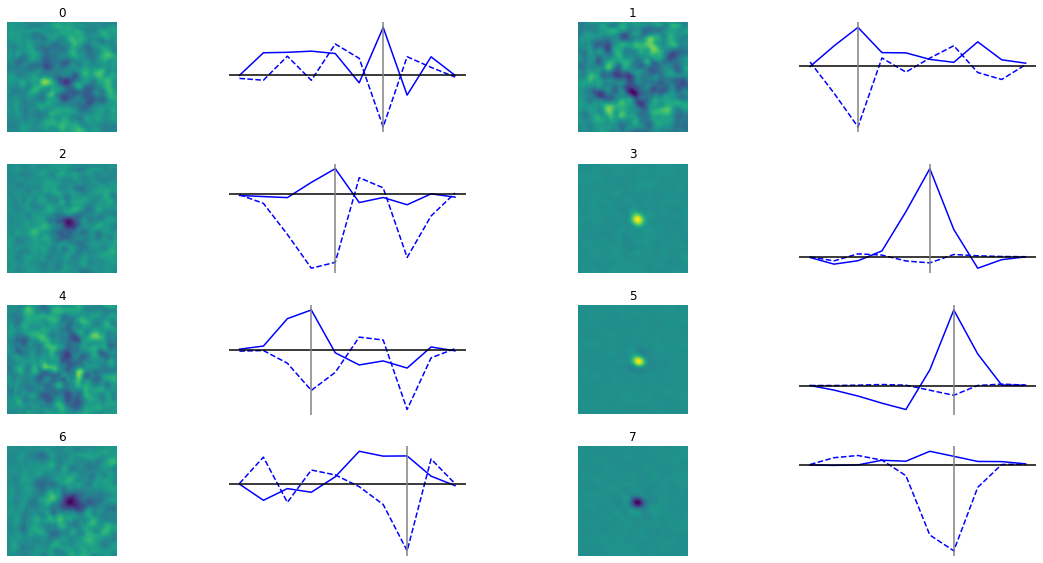

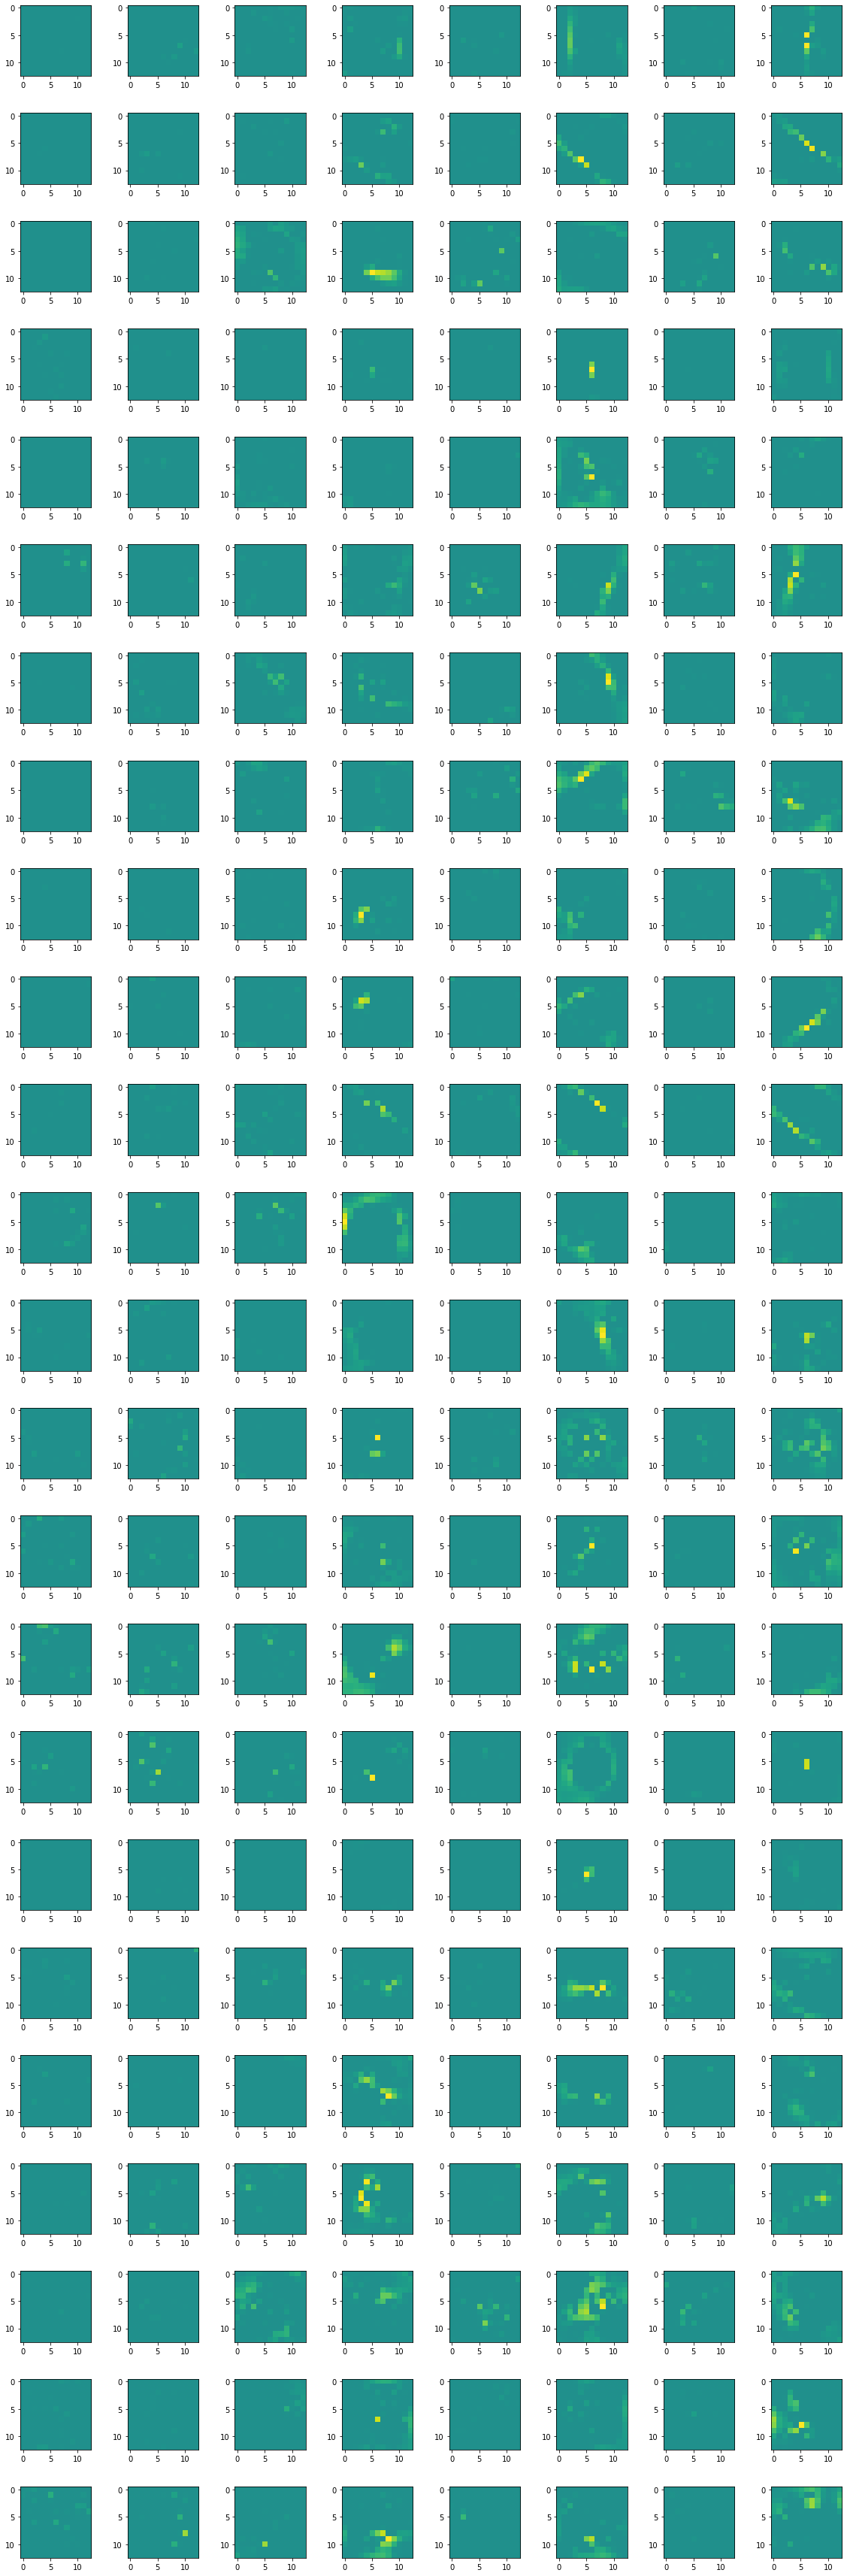

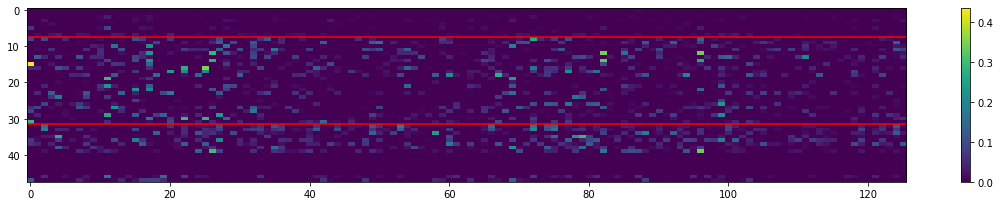

[0.02630559 0.61965592 0.35403849]


In [42]:
CU.display_cnn(cnn2x)

Text(0, 0.5, 'CNN2')

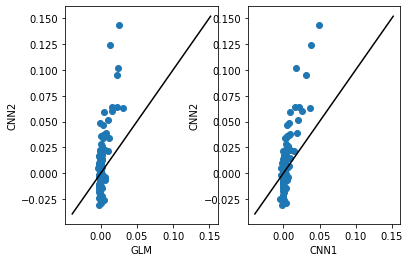

In [43]:
LLsCNN2 = LLsNULL-LLs2x
plt.subplot(1,2,1)
plt.plot(LLsGLM,LLsCNN2,'o')
ys = plt.ylim()
plt.plot(ys,ys,'k')
plt.xlabel('GLM')
plt.ylabel('CNN2')

plt.subplot(1,2,2)
plt.plot(LLsCNN1,LLsCNN2,'o')
ys = plt.ylim()
plt.plot(ys,ys,'k')
plt.xlabel('CNN1')
plt.ylabel('CNN2')

In [44]:
cnn2x.save_model(filename=moddir+'cnn'+fndate+'bdata1.pkl')

  Saving model at /Data/FelixData/Conway/proc/J220711/models/cnn0711bdata1.pkl


### Eye tracking second iteration

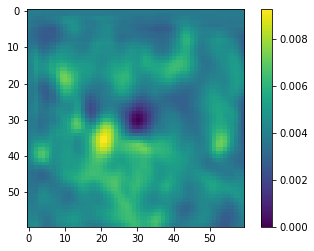

(1.7300974849447165e-16, [30, 30])

In [45]:
cnn2C, sh2C, LC = ETutils.convolutional_convert_cnn(cnn2x.cpu(), verbose=0)

preds0 = cnn2x(data[:10]).detach().numpy()
predsC = cnn2C(data[:10]).reshape([preds0.shape[0],NCv,NX,NX]).detach().numpy()
sims = np.zeros([NX, NX])
for ii in range(NX):
    for jj in range(NX):
        sims[ii,jj] = np.mean(np.square(preds0-predsC[:,:,ii,jj]))
imagesc(sims)
plt.colorbar()
plt.show()
cntr = utils.max_multiD(-sims)

np.min(sims), cntr

Only showing the first 36 fixations


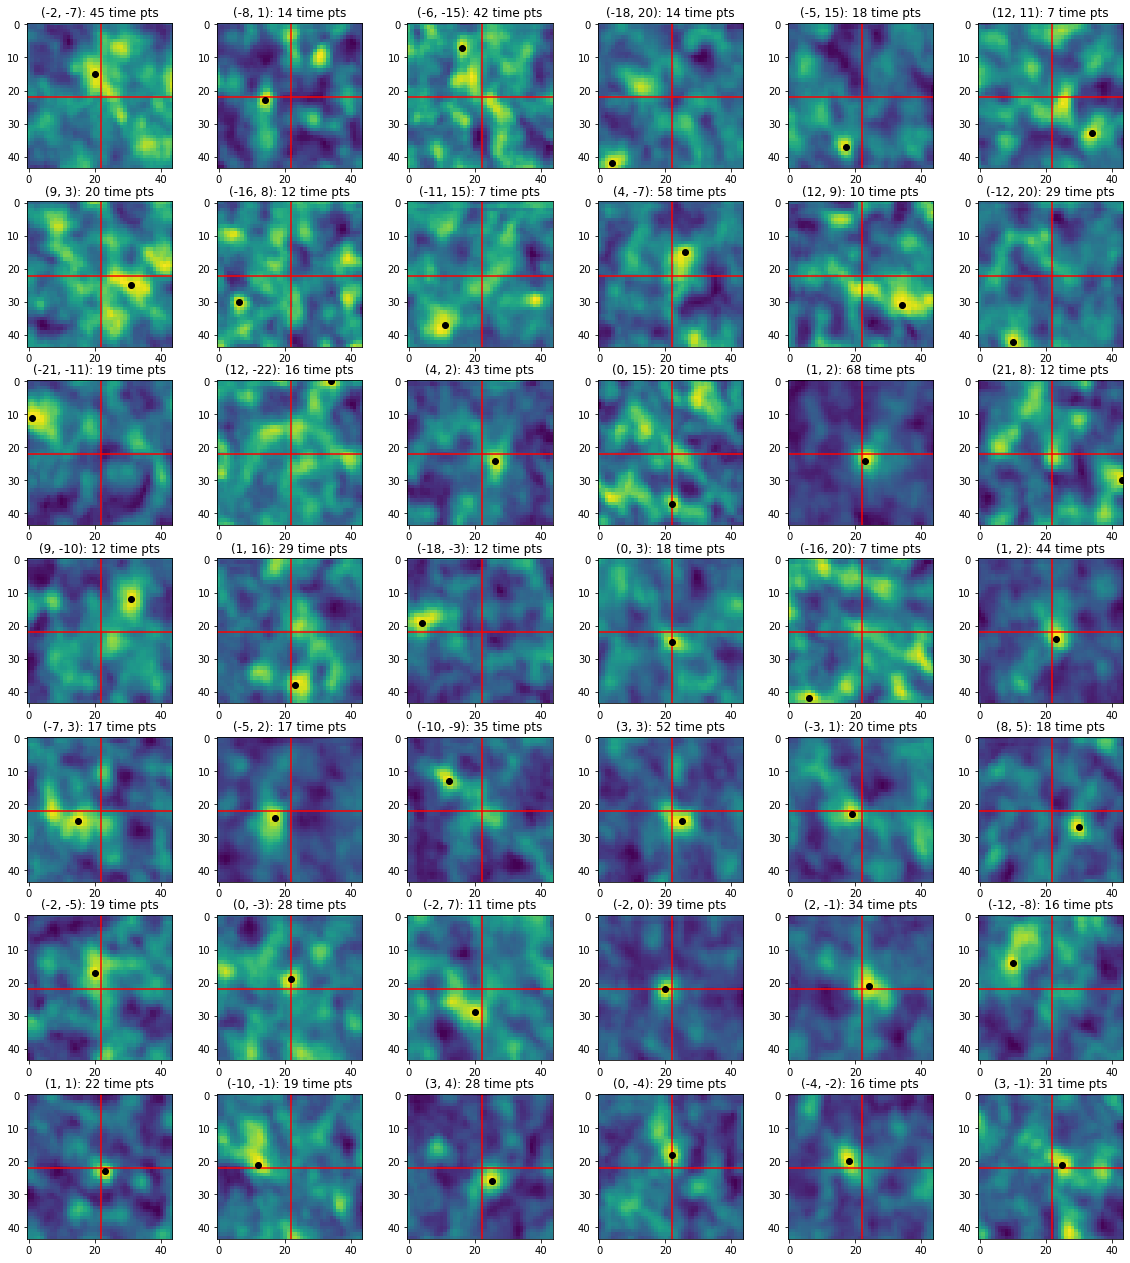

In [46]:
edge1 = 8
data.trial_sample=False # set as kludge for computing LLsurfaces

#res0 = ETutils.compute_LLsurfaces( 
#    data, cnn1C, drift_all, fixations=np.arange(10), # np.arange(Lfix_range[0], Lfix_range[0]+12),
#    edge=edge1, ctr = cntr1, display=True)

res0 = ETutils.compute_LLsurfaces(
    data, cnn2C, drift_all, edge=edge1, ctr=cntr, extra_data=True,
    fixations=np.arange(18,60), wpriors=1e-4, device=device, display=True, fighandle=False)

Only showing the first 36 fixations


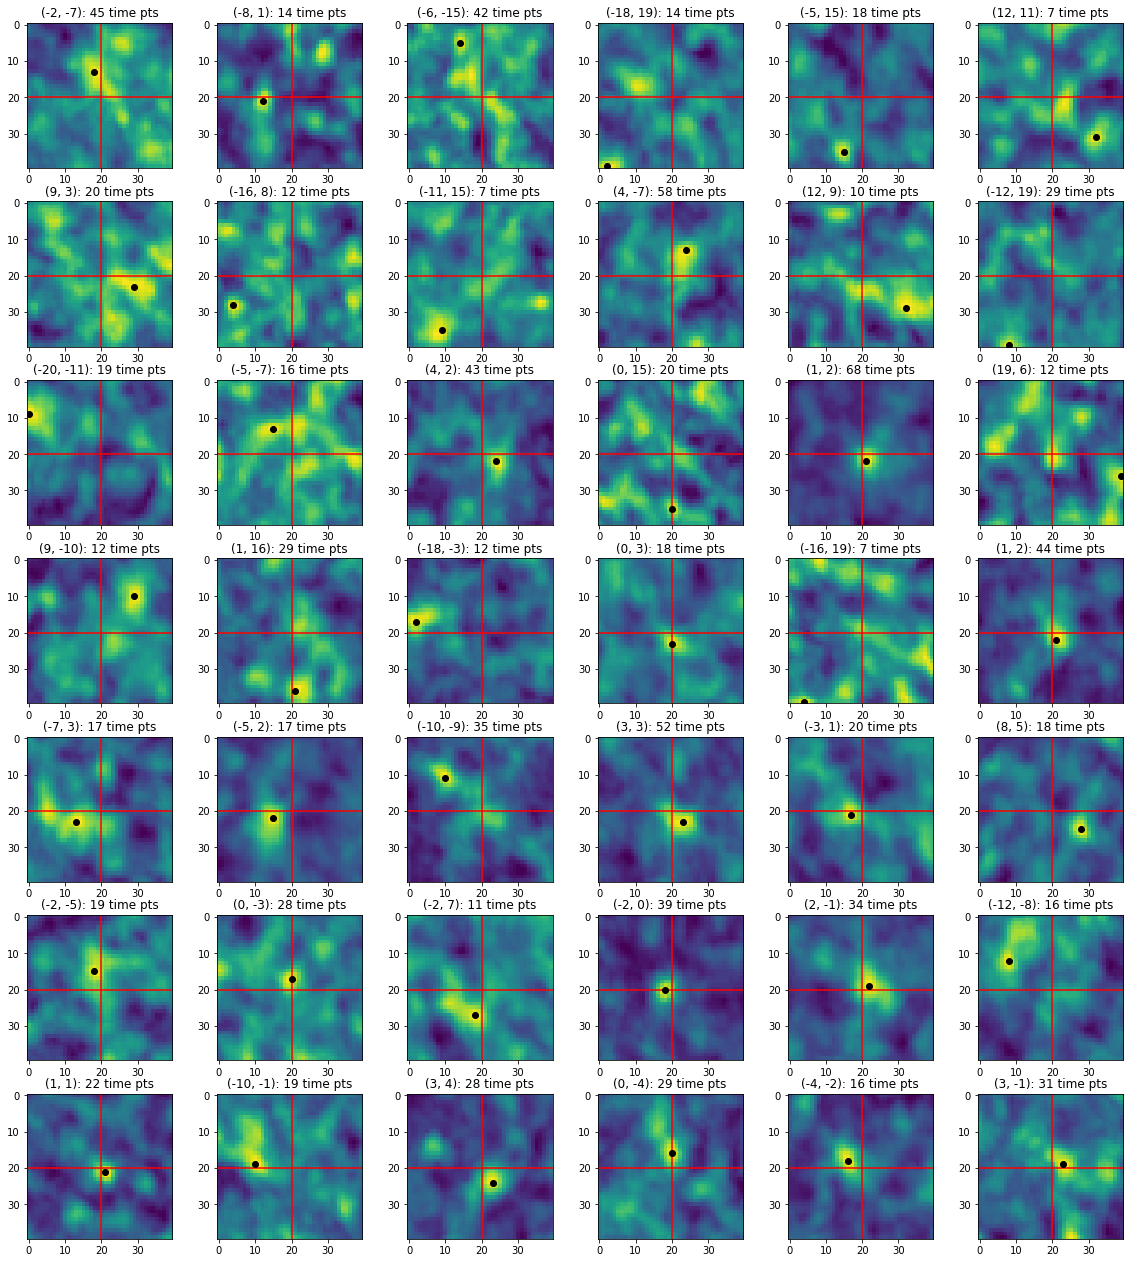

In [47]:
edge1 = 10
#res0 = ETutils.compute_LLsurfaces( 
#    data, cnn1C, drift_all, fixations=np.arange(10), # np.arange(Lfix_range[0], Lfix_range[0]+12),
#    edge=edge1, ctr = cntr1, display=True)
res1 = ETutils.compute_LLsurfaces(
    data, cnn2C, drift_all, edge=edge1, ctr=cntr, extra_data=True,
    fixations=np.arange(18,60), wpriors=1e-4, device=device, display=True, fighandle=False)

In [48]:
#from NDNT.utils.DanUtils import figure_export
#figure_export( res1, analdir+'ETsurfexamp5_'+fn+'.pdf' )

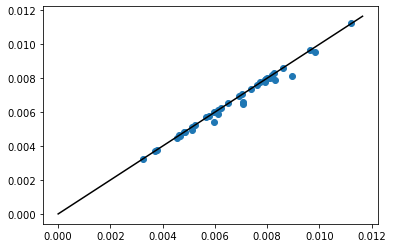

In [49]:
plt.plot(res0['metrics'], res1['metrics'],'o')
ys = plt.ylim()
plt.plot([0, ys[1]],[0, ys[1]],'k')
plt.show()

In [50]:
Ngroups = 4
priors = [0.0001, 0.003, 0.001, 0.03, 0.1, 0.3]

fixgroups = []
for nn in range(Ngroups):
    if nn == Ngroups-1:
        ender = NFIX
    else:
        ender = ((nn+1)*NFIX)//Ngroups

    fixgroups.append(np.arange(nn*NFIX//Ngroups, ender))

thresh_metrics2 = []
resCNN = []

for ii in range(Ngroups):
    print( 'Fix group', ii)
    resCNN.append( 
        ETutils.compute_LLsurfaces(data, cnn2C, drift_all, edge=edge1, ctr=cntr, extra_data=True,
                                   fixations=fixgroups[ii], wpriors=priors, device=device) )
    thresh_ms = np.zeros(len(fixgroups[ii]))
    for ff in range(len(fixgroups[ii])):
        _, thresh_ms[ff] = CU.surf2D_quality_scan( resCNN[-1]['LLsurfaces'][ff,:,:,0] )
    thresh_metrics2 = np.concatenate( (thresh_metrics2, thresh_ms), axis=0 )
#ETnim = stitch_results( resNIM )
ETcnn2 = CU.stitch_results( resCNN )

Fix group 0
  500 fixations
  1000 fixations
  1500 fixations
Fix group 1
  500 fixations
  1000 fixations
  1500 fixations
Fix group 2
  500 fixations
  1000 fixations
  1500 fixations
Fix group 3
  500 fixations
  1000 fixations
  1500 fixations


In [51]:
val_ds = GenericDataset(data[data.val_blks], device=device)

data.trial_sample=True # set as kludge for computing LLsurfaces

cnn2 = cnn2x.to(device)
LLs0 = cnn2x.eval_models(val_ds, null_adjusted=False)
Ukeeps = ETcnn2['Ctrain']
XVkeeps = ETcnn2['Cval']
print("U: %0.8f\tXV: %0.8f"%(np.mean(LLsNULL[Ukeeps]-LLs0[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0[XVkeeps])) )

Eval models: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]

U: -0.06146012	XV: 0.15457217


In [52]:
# COMPUTE OPTIMAL PERFORMACE USING Xval;
NP = len(priors)
LLet2 = np.zeros([NP, 2])
data2.set_cells(valET)

#qs = [0, 0.05, 0.01, 0.2, 0.3]  # how much data to throw out based on metrics
# metric_thresholds = [] 
#     cuts = np.quantile(ETcnn['metrics'][:, pp], qs)
#     metric_thresholds.append(deepcopy(cuts))

# Old comparison
print("Train   \tValidation")
print("%8.6f\t%8.6f"%(np.mean(LLsNULL[Ukeeps]-LLs0[Ukeeps]), np.mean(LLsNULL[XVkeeps]-LLs0[XVkeeps])) )

for pp in range(NP):
    print( "  Prior = %f"%priors[pp])
    shifts = ETcnn2['shifts'][:, :, pp] - NX//2 + edge1
    new_stim2 = data.shift_stim( -shifts  )
    data2.stim = new_stim2.reshape([NT,-1])
  
    torch.cuda.empty_cache()
    val_dsN = GenericDataset(data2[data.val_blks], device=device)

    LLsN = cnn2x.eval_models(val_dsN, null_adjusted=False)
    print("p%d: %8.6f\t%8.6f"%(pp, np.mean(LLsNULL[Ukeeps]-LLsN[Ukeeps]), 
                                  np.mean(LLsNULL[XVkeeps]-LLsN[XVkeeps])) )
    LLet2[pp, 0] = np.mean(LLsNULL[XVkeeps]-LLsN[XVkeeps])  # XVcells
    LLet2[pp, 1] = np.mean(LLsNULL[Ukeeps]-LLsN[Ukeeps])  
    del val_dsN

Output set to 126 cells
Train   	Validation
-0.061460	0.154572
  Prior = 0.000100


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.10it/s]


p0: -0.014788	-0.008581
  Prior = 0.003000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.09it/s]


p1: -0.014316	-0.008944
  Prior = 0.001000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.09it/s]


p2: -0.014542	-0.009052
  Prior = 0.030000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.08it/s]


p3: -0.014972	-0.008727
  Prior = 0.100000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.09it/s]


p4: -0.014644	-0.009662
  Prior = 0.300000


Eval models: 100%|█████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.09it/s]

p5: -0.014567	-0.009533


### Generate shifts 

In [53]:
pp = 1
shifts2 = deepcopy(ETcnn2['shifts'][:, :, pp]) - NX//2 + edge1
fix_n = deepcopy(data.fix_n.detach().numpy())
metricsLL2 = deepcopy(ETcnn2['metrics'][:,pp])
metricsTH2 = deepcopy(thresh_metrics2)
shifts2.shape, fix_n.shape, metricsLL2.shape, metricsTH2.shape

((6033, 2), (154320,), (6033,), (6033,))

In [54]:
# Make continuous-in-time
ETshifts2 = np.zeros([data.NT,2], dtype=np.float32)
ETmetrics2 = np.zeros([data.NT,2], dtype=np.float32)
for ff in range(NFIX):
    ts = np.where(fix_n == (ff+1))[0]
    ETshifts2[ts, 0] = shifts2[ff,0]
    ETshifts2[ts, 1] = shifts2[ff,1]
    ETmetrics2[ts, 0] = metricsLL2[ff]
    ETmetrics2[ts, 1] = metricsTH2[ff]

sio.savemat( datadir2 + fn +'shifts1.mat', {
    'fix_n': fix_n, 'shifts': shifts2, 'metricsLL': metricsLL2, 'metricsTH': metricsTH2,
    'ETshifts': ETshifts2, 'ETmetrics': ETmetrics2, 'Ctrain': Ukeeps, 'Cval': XVkeeps} )

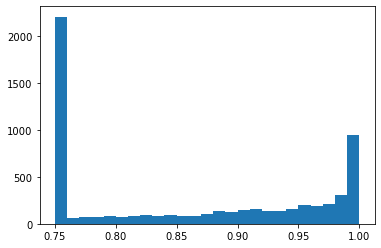

In [55]:
# Check metrics on histogram 
plt.hist(metricsTH2,bins=25)
plt.show()

In [59]:
goodfix = np.where(ETmetrics2[:,1] < 0.95)[0]
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics2.shape[0]))

75.5% fixations remaining


In [57]:
fndate

'0711'

In [60]:
# if the second run was actually better, we overwrite the first
sio.savemat( datadir2 + fn + '_shifts_best.mat', {
    'fix_n': fix_n, 'shifts': shifts2, 'metricsLL': metricsLL2, 'metricsTH': metricsTH2,
    'ETshifts': ETshifts2, 'ETmetrics': ETmetrics2, 'Ctrain': Ukeeps, 'Cval': XVkeeps} )